In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init
import sys

sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel
import random
from torch.autograd import Variable

In [2]:
df = pd.read_hdf("/data/t3home000/spark/LHCOlympics_previous/preprocessed_40part_testdataset.h5")

In [3]:
dt = df.values

In [4]:
dt.shape

(1100000, 121)

In [5]:
idx = dt[:,120]
bkg_idx = np.where(idx==0)[0]
sig_idx = np.where(idx==1)[0]

In [6]:
dt = dt[:,:120]
label = idx

In [7]:
dt.shape

(1100000, 120)

In [8]:
label.shape

(1100000,)

In [9]:
data = np.reshape(dt, (-1,40,3))

In [10]:
data.shape

(1100000, 40, 3)

In [11]:
label

array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
data_bkg = dt[bkg_idx]

data_sig = dt[sig_idx]

data_bkg = data_bkg[:,0:120]

data_sig = data_sig[:,0:120]

data_bkg = np.reshape(data_bkg, (-1,40,3))

data_bkg.shape # (Nevents, Npfcands, Nfeats)

data_sig = np.reshape(data_sig, (-1,40,3))

data_sig.shape

(100000, 40, 3)

In [13]:
from sklearn.model_selection import train_test_split

sig_train, sig_test = train_test_split(data_sig, test_size=0.2)

In [17]:
np.max(data[:,:,0])

1.0

In [14]:
sig_train.shape

(80000, 40, 3)

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)


    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [16]:
class particleTransformer(nn.Module):
    def __init__(self, particle_feature_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_seq_length, pos_dropout, trans_dropout):
        super().__init__()
        self.d_model = d_model
        self.embed_src = nn.Linear(particle_feature_size, d_model)
        self.embed_tgt = nn.Linear(particle_feature_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, trans_dropout)
        self.fc = nn.Linear(d_model, particle_feature_size)

    def forward(self, src, tgt):

        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        
        src = self.pos_enc(self.embed_src(src) * math.sqrt(self.d_model))
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))
        
        
        #output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
        #                          tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        output = self.transformer(src, tgt)
        return self.fc(output).permute(1,0,2)


In [18]:
linear_net = nn.Linear(3,512)

input_tensor = torch.rand((40,100,3))

out = linear_net(input_tensor)

out.shape

pos_enc = PositionalEncoding(512, 0.1, 512)

withenc = pos_enc(out)

withenc.shape

torch.arange(0, 40, dtype=torch.float).unsqueeze(1).shape

torch.Size([40, 1])

In [15]:
data_sig.shape

(100000, 40, 3)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'GeForce RTX 2080 Ti'

In [18]:
model = particleTransformer(3, 512, 8, 2, 2, 5, 512, .2, .2).to(device)
#self, input_size, hidden_size, latent_size,num_layers=2, bidirectional=False):

In [21]:
lr = 1e-3
bs = 1000
optimizer = optim.Adam(model.parameters(), lr=lr)

In [22]:
tensor_sig_train = torch.tensor(sig_train) 

tensor_sig_train.shape

sig_train_iterator = utils.DataLoader(tensor_sig_train, batch_size=bs, shuffle=True)

In [23]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, x in enumerate(sig_train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.float().cuda()

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample = model(x,x)

        # reconstruction loss
        recon_loss = F.mse_loss(x_sample, x, size_average=False)


        # total loss
        loss = recon_loss 
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()
        
    return train_loss


In [24]:
best_train_loss = float('inf')

for e in range(1000):

    train_loss = train()

    train_loss /= len(tensor_sig_train)
    print(train_loss)
    if best_train_loss > train_loss:
        best_train_loss = train_loss
        patience_counter = 1
        print("Saving model!")
        torch.save(model.state_dict(),"/data/t3home000/spark/QUASAR/weights/transformer.h5")

    else:
        patience_counter += 1
        print("Not saving model!")

    if patience_counter > 5:
        print("Patience Limit Reached")
        break

/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


59.845706469726565
Saving model!
8.080820239257813
Saving model!
4.6188068359375
Saving model!
3.3140722045898436
Saving model!
2.713454833984375
Saving model!
2.208484535217285
Saving model!
1.9437116912841796
Saving model!
1.792526106262207
Saving model!
1.7186556838989258
Saving model!
1.464576448059082
Saving model!
1.4220632553100585
Saving model!
1.3149206665039062
Saving model!
1.277466862487793
Saving model!
1.1998305053710938
Saving model!
1.1475020729064942
Saving model!
1.064924892425537
Saving model!
1.0407346008300782
Saving model!
0.9911330169677735
Saving model!
1.0206512062072755
Not saving model!
0.9118977088928223
Saving model!
0.8854059806823731
Saving model!
0.8396730453491211
Saving model!
0.8420523803710938
Not saving model!
0.7843833984375
Saving model!
0.781239363861084
Saving model!
0.7268326019287109
Saving model!
0.7500855644226074
Not saving model!
0.6966028167724609
Saving model!
0.6795824508666992
Saving model!
0.6568969429016114
Saving model!
0.6383875129

In [19]:
model.load_state_dict(torch.load("/data/t3home000/spark/QUASAR/weights/transformer.h5"))

<All keys matched successfully>

In [20]:
model.eval()

particleTransformer(
  (embed_src): Linear(in_features=3, out_features=512, bias=True)
  (embed_tgt): Linear(in_features=3, out_features=512, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=5, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=5, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
        (1): TransformerEncoderLayer(


In [28]:
type(data_sig)

numpy.ndarray

In [31]:
sig_test.shape

(20000, 40, 3)

In [33]:
data_bkg.shape

(1000000, 40, 3)

In [21]:
xprime = model(torch.Tensor(data_sig[:500]).cuda(),torch.Tensor(data_sig[:500]).cuda())

In [45]:
xprime_bkg = model(torch.Tensor(data_bkg[:500]).cuda(),torch.Tensor(data_bkg[:500]).cuda())

In [58]:
xprime.shape

torch.Size([500, 40, 3])

In [65]:
xprime.shape

torch.Size([500, 40, 3])

In [63]:
xprime.reshape(-1,120).shape

torch.Size([500, 120])

In [66]:
loss_sig = torch.mean((xprime.reshape(-1,120)-torch.Tensor(sig_test[:500]).reshape(-1,120).cuda())**2,dim=1).data.cpu().numpy()

In [67]:
loss_sig.shape

(500,)

In [69]:
loss_bkg = torch.mean((xprime_bkg.reshape(-1,120)-torch.Tensor(data_bkg[:500]).reshape(-1,120).cuda())**2,dim=1).data.cpu().numpy()

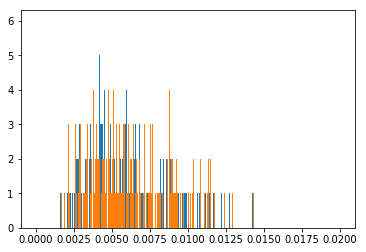

In [75]:
plt.hist(loss_sig,bins=np.linspace(0,0.02,1000));
plt.hist(loss_bkg,bins=np.linspace(0,0.02,1000));

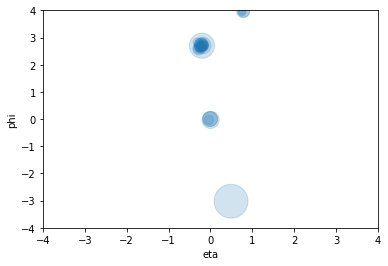

In [42]:
plot_event(data_bkg[3],"bkgtest3_actual")

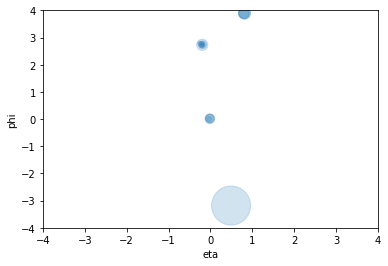

In [43]:
plot_event(xprime_bkg[3].cpu().detach().numpy(),"bkgtest3_transformerReconstructed")

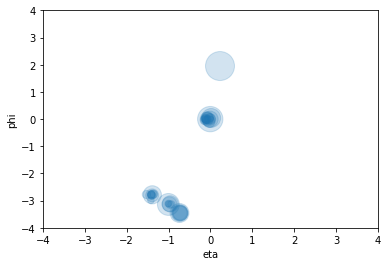

In [29]:
plot_event(data_sig[6],"sigtest6_actual")

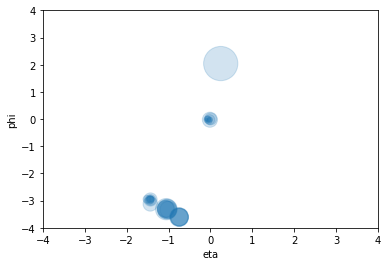

In [28]:
plot_event(xprime[6].cpu().detach().numpy(),"sigtest6_transformerReconstructed")

In [23]:
data_sig[0:4].shape

(4, 40, 3)

In [37]:
recons, kld = model(torch.Tensor(data_sig[0:10]).cuda())

In [26]:
recons_bkg, kld = model(torch.Tensor(data_bkg[0:4]).cuda())

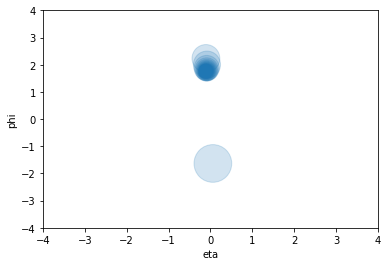

In [29]:
plot_event(recons_bkg[0].cpu().detach().numpy(),"sigAE_recons_0")

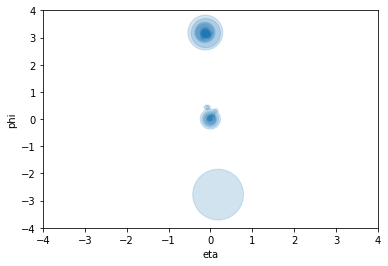

In [30]:
plot_event(data_bkg[0],"bkg_actual_0")

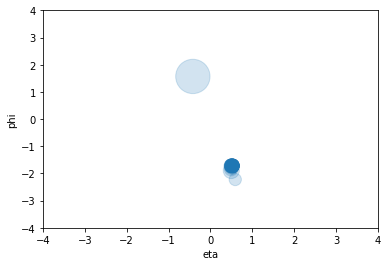

In [38]:
plot_event(recons[4].cpu().detach().numpy(),"sigAE_siginal_recons_4")

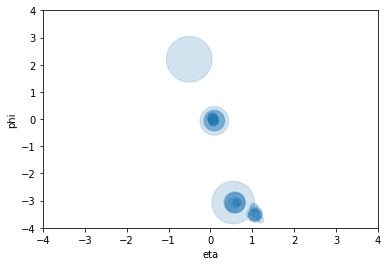

In [36]:
plot_event(data_sig[4],"sig_actual_4")

In [39]:
model_bkg = SentenceVAE(3,10,4).to(device)


In [40]:
tensor_bkg_train = torch.tensor(data_bkg) 

tensor_bkg_train.shape

bkg_train_iterator = utils.DataLoader(tensor_bkg_train, batch_size=bs, shuffle=True)

In [41]:
lr = 1e-3
bs = 1000
optimizer = optim.Adam(model_bkg.parameters(), lr=lr)

In [42]:
loss

NameError: name 'loss' is not defined

In [43]:
def train_bkg():
    # set the train mode
    model_bkg.train()

    # loss of the epoch
    train_loss = 0

    for i, x in enumerate(bkg_train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.float().cuda()

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, kld = model_bkg(x)

        # reconstruction loss
        recon_loss = F.mse_loss(x_sample, x, size_average=False)


        # total loss
        loss = recon_loss + kld
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()
        
    return train_loss


In [ ]:
best_train_loss = float('inf')

for e in range(1000):

    train_loss = train_bkg()

    train_loss /= len(tensor_bkg_train)
    print(train_loss)
    if best_train_loss > train_loss:
        best_train_loss = train_loss
        patience_counter = 1
        print("Saving model!")
        torch.save(model_bkg.state_dict(),"/data/t3home000/spark/QUASAR/weights/seq2seq_bkg.h5")

    else:
        patience_counter += 1
        print("Not saving model!")

    if patience_counter > 5:
        print("Patience Limit Reached")
        break

166.1377109375
Saving model!
127.464282109375
Saving model!
123.112391984375
Saving model!
122.618069015625
Saving model!
121.7259961484375
Saving model!


# MAKE DATASET

In [ ]:
import torch
from torch_geometric.data import InMemoryDataset, download_url

In [ ]:
class DijetAnomaly(InMemoryDataset):
    

# Make Plotting Scripts, Will later make into a separate module

In [22]:
def plot_event(pfcands, name):

    pt = pfcands[:,0]
    eta = pfcands[:,1]
    phi = pfcands[:,2]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(eta,phi,s=pt*10000, alpha=0.2)
    ax.set_xlabel('eta')
    ax.set_ylabel('phi')
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])
    fig.savefig(f'figures/{name}.png')

In [ ]:
plot_event(data_sig[4],"event_sig_idx4")

# 40 Body System, 3 features ( pT, eta, Phi) for each object (PF candidate)

In [ ]:
n_objects  = 40 # number of PF candidates(nodes)
object_dim = 3 # features: mass, x coordinate, y coordinate, speed on x-axis, speed on y-axis

n_relations  = n_objects * (n_objects - 1) # number of edges in fully connected graph
relation_dim = 1

effect_dim = 10 #effect's vector size


In [ ]:
n_relations

In [ ]:
data.shape

In [ ]:
def get_batch(data, label, idx, batch_size):
    
    start_idx = idx*batch_size
    end_idx = idx*batch_size+batch_size

    batch_data = data[start_idx: end_idx]
    label_data = label[start_idx: end_idx]
    
    objects = batch_data
    
    
    #receiver_relations, sender_relations - onehot encoding matrices
    #each column indicates the receiver and sender object’s index
    
    receiver_relations = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    sender_relations   = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    
    cnt = 0
    for i in range(n_objects):
        for j in range(n_objects):
            if(i != j):
                receiver_relations[:, i, cnt] = 1.0
                sender_relations[:, j, cnt]   = 1.0
                cnt += 1
    
    #There is no relation info in solar system task, just fill with zeros
    relation_info = np.zeros((batch_size, n_relations, relation_dim))
    target = label_data
    
    objects            = Variable(torch.FloatTensor(objects))
    sender_relations   = Variable(torch.FloatTensor(sender_relations))
    receiver_relations = Variable(torch.FloatTensor(receiver_relations))
    relation_info      = Variable(torch.FloatTensor(relation_info))
    target             = Variable(torch.FloatTensor(target))
                       
    if USE_CUDA:
        objects            = objects.cuda()
        sender_relations   = sender_relations.cuda()
        receiver_relations = receiver_relations.cuda()
        relation_info      = relation_info.cuda()
        target             = target.cuda()
    
    return objects, sender_relations, receiver_relations, relation_info, target


In [ ]:
class RelationalModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RelationalModel, self).__init__()
        
        self.output_size = output_size
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )
    
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_relations, input_size]
        Returns:
            [batch_size, n_relations, output_size]
        '''
        batch_size, n_relations, input_size = x.size()
        x = x.view(-1, input_size)
        x = self.layers(x)
        x = x.view(batch_size, n_relations, self.output_size)
        return x

In [ ]:
class ObjectModel(nn.Module):
    def __init__(self, input_size, hidden_size, D):
        super(ObjectModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1), #speedX and speedY
        )
        
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_objects, input_size]
        Returns:
            [batch_size * n_objects, 2] speedX and speedY
        '''
        input_size = x.size(2)*x.size(1)
        x = x.view(-1, input_size)
        return self.layers(x)


In [ ]:
class InteractionNetwork(nn.Module):
    def __init__(self, n_objects, object_dim, n_relations, relation_dim, effect_dim):
        super(InteractionNetwork, self).__init__()
        
        self.relational_model = RelationalModel(2*object_dim + relation_dim, effect_dim, 150)
        self.object_model     = ObjectModel((object_dim + effect_dim)*n_objects, 100)
    
    def forward(self, objects, sender_relations, receiver_relations, relation_info):
        senders   = sender_relations.permute(0, 2, 1).bmm(objects)
        receivers = receiver_relations.permute(0, 2, 1).bmm(objects)
        effects = self.relational_model(torch.cat([senders, receivers, relation_info], 2))
        effect_receivers = receiver_relations.bmm(effects)
        predicted = self.object_model(torch.cat([objects, effect_receivers], 2))
        return predicted

In [ ]:
USE_CUDA = True

In [ ]:
interaction_network = InteractionNetwork(n_objects, object_dim, n_relations, relation_dim, effect_dim)

if USE_CUDA:
    interaction_network = interaction_network.cuda()
    
optimizer = optim.Adam(interaction_network.parameters())
criterion = nn.BCEWithLogitsLoss()



In [ ]:
n_epoch = 100
batch_size=1000
batches_per_epoch = int(len(data)/batch_size)

losses = []
for epoch in range(n_epoch):
    for idx in range(batches_per_epoch):
        print((idx/batches_per_epoch)*100,"percent")
        objects, sender_relations, receiver_relations, relation_info, target = get_batch(data, label, idx, batch_size)
        predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)
        loss = criterion(predicted.flatten(), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.cpu().numpy())
        
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Epoch %s RMS Error %s' % (epoch, np.sqrt(np.mean(losses[-100:]))))
    plt.plot(losses)
    plt.show()